# Analyzing region 6 data

Region 6 is home to [Schedule 03FAC][], Facilities Maintenance and Management. We've been informed through user research interviews that its data is highly geographic, so this notebook is an attempt to analyze its data from a geographic perspective.

Techniques used in this notebook were learned from Christy Heaton's Pycon 2018 tutorial on [Intro to Spatial Analysis and Maps][] (see also its [Github repo]()).

[Schedule 03FAC]: https://www.gsa.gov/acquisition/purchasing-programs/gsa-schedules/list-of-gsa-schedules/schedule-03facfacilities-maintenance-and-management

[Intro to Spatial Analysis and Maps]: https://www.youtube.com/watch?v=uRvTeK5Ndq8

[Github repo]: https://github.com/christyheaton/PyCon2018_GISTutorial

In [1]:
%matplotlib inline

from pathlib import Path
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt

## Load the Region 6 data

In [2]:
DATA_DIR = Path('..').resolve() / 'data'

# Alias some of our column names, as we'll be using them later.
SERVICE = 'SERVICE PROPOSED (e.g. Job Title/Task)'
HQ_STATE = 'Contractor Headquarters (State)'

rows = pd.read_csv(str(DATA_DIR / 'region_6_prices.csv'))

# The first row is just instructions rather than data, so let's remove it.
rows.drop(rows.index[0], inplace=True)

rows.head()

,SIN(s) PROPOSED,SERVICE PROPOSED (e.g. Job Title/Task),MINIMUM EDUCATION/ CERTIFICATION LEVEL,MINIMUM YEARS OF EXPERIENCE,WORKSITE,Domestic or Overseas,"UNIT OF ISSUE (e.g. Hour, Task, Sq ft)",PRICE OFFERED TO GSA (excluding IFF),PRICE OFFERED TO GSA (including IFF),Supporting Invoice or Document Number (Initial submittal),Page Location,CONTRACT NUMBER,VENDOR NAME,BUSINESS SIZE,SCHEDULE,CURRENT CONTRACT YEAR,CONTRACT START DATE,CONTRACT END DATE,Contractor Headquarters (State)
1,132-51,Project Manager,Bachelors,5,Both,NaN,Hour,$110.99,$115.99,03.130008.01-1,1,GS-35F-XXXX,Greatness Inc.,S,IT Schedule 70,2,5/15/2015,5/4/2020,CA
2,811-002,Principal,Bachelors,10,Customer,Domestic,Hour,$97.44,$97.44,NaN,NaN,GS-21F-0040V,ASon's Contruction,S,03FAC,3,NaN,2/5/2019,IN
3,811-002,Program Manager,Bachelors,7,Customer,Domestic,Hour,NaN,$90.94,NaN,NaN,GS-21F-0040V,ASon's Contruction,S,03FAC,3,NaN,2/5/2019,IN
4,811-002,Project Manager,Bachelors,5,Customer,Domestic,Hour,NaN,$84.45,NaN,NaN,GS-21F-0040V,ASon's Contruction,S,03FAC,3,NaN,2/5/2019,IN
5,811-002,Project Manager II,Bachelors,3,Customer,Domestic,Hour,NaN,$77.95,NaN,NaN,GS-21F-0040V,ASon's Contruction,S,03FAC,3,NaN,2/5/2019,IN


## Load shapefiles for U.S. states

These shapefiles were taken from the [U.S. Census Bureau](https://www.census.gov/geo/maps-data/data/cbf/cbf_state.html).

In [3]:
STATES_PATH = DATA_DIR / 'us_states' / 'cb_2017_us_state_500k.shp'

states = gpd.read_file(str(STATES_PATH))

The coordinate reference system appears to correspond to the [North American Datum of 1983](https://en.wikipedia.org/wiki/North_American_Datum#North_American_Datum_of_1983) (NAD 83).

In [4]:
states.crs

{'init': 'epsg:4269'}

Um, because I am a GIS noob and don't know how to display really far-away places in an inset view, I'm only going to show the continental states here.

In [5]:
NON_CONTINENTAL_PLACES = [
    'Hawaii', 'Guam', 'Alaska', 'Commonwealth of the Northern Mariana Islands',
    'American Samoa', 'Puerto Rico', 'United States Virgin Islands'
]

for place in NON_CONTINENTAL_PLACES:
    states = states[states['NAME'] != place]

We'll also re-index the states to be by their two-letter postal code, as this will make it easy for us to join against our region 6 data.

In [6]:
states.set_index('STUSPS', inplace=True)

## Chart our services per state

This might not actually be a terribly helpful visualization, because we're categorizing services by the state in which the company that offers them is headquartered in.  It is _not_ categorized by where the services themselves are offered!

But hey, it's a chloropeth, and I've never made a chloropeth before! So this is still a win.

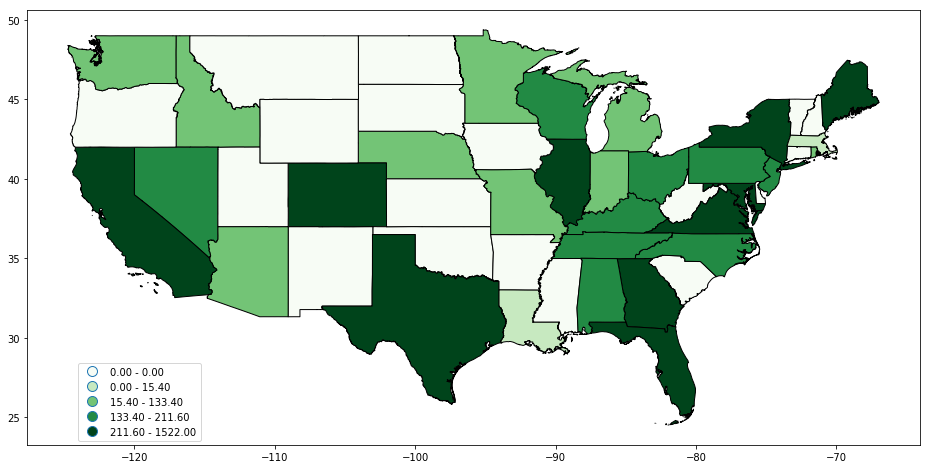

In [7]:
svcs_per_state = rows.groupby(HQ_STATE)[SERVICE].count()
svcs_per_state = states.join(svcs_per_state)
svcs_per_state[SERVICE].fillna(0, inplace=True)

fig, ax = plt.subplots(1, figsize=(16,8))

svcs_per_state.plot(ax=ax, column=SERVICE, cmap='Greens', scheme='quantiles', edgecolor='black', legend=True)

legend = ax.get_legend()
legend.set_bbox_to_anchor((0., 0., 0.2, 0.2))